In [1]:
!pip install tqdm

You should consider upgrading via the '/media/farhood/Data/Courses/Bio Master Courses/Spring 1400/Machine Learning/Final Project/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import json

import pandas as pd
import numpy as np

from sklearn.preprocessing import *
from sklearn.cluster import *
from sklearn.decomposition import *
from sklearn.manifold import TSNE
from tqdm.auto import tqdm


import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [3]:
with open("data/processed/processed_data.json") as pfile:
    info = json.load(pfile)

df = pd.DataFrame(info["df"])
train_indices = info["train_indices"]
test_indices = info["test_indices"]
val_indices = info["val_indices"]

encoder = {
    "gender": LabelEncoder(),
    "status": LabelEncoder(),
    "age": KBinsDiscretizer(encode="ordinal")
}

gender_vec = encoder["gender"].fit_transform(df["Gender"])
status_vec = encoder["status"].fit_transform(df["Status"])
age_vec = encoder["age"].fit_transform(df["Age"].values.reshape(-1, 1)).squeeze()
print(age_vec.shape)

(2545,)


In [4]:
X = df["features"].values.tolist()
X = np.asarray([np.array(x) for x in X])
print(X.shape)


X_train = X[train_indices]
X_val = X[val_indices]
X_test = X[test_indices]

(2545, 25)


In [5]:
x2d = TSNE(verbose=True).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2545 samples in 0.001s...
[t-SNE] Computed neighbors for 2545 samples in 0.567s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2545
[t-SNE] Computed conditional probabilities for sample 2000 / 2545
[t-SNE] Computed conditional probabilities for sample 2545 / 2545
[t-SNE] Mean sigma: 17.681175
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.013832
[t-SNE] KL divergence after 1000 iterations: 1.169015


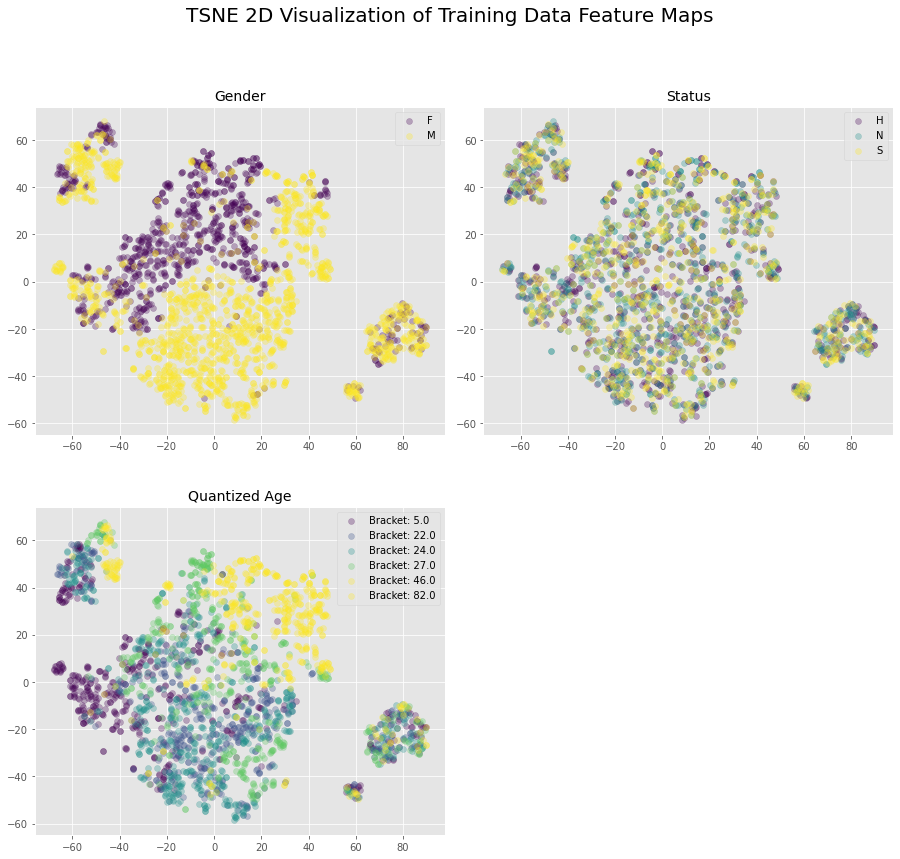

In [39]:
cmap = plt.get_cmap("viridis", len(encoder["gender"].classes_))
fig, axes = plt.subplots(2, 2, figsize=(14,13))
axes = list(axes.flat)
fig.delaxes(axes[3])
ax = axes[0]
for idx, c in enumerate(encoder["gender"].classes_):
    selected_indices = gender_vec == idx
    ax.scatter(
        x2d[selected_indices, 0], 
        x2d[selected_indices, 1], 
        alpha=0.3,
        label=c,
        color=cmap(idx),
    )

ax.set_title("Gender", fontsize=14)
ax.set_aspect("equal")
ax.legend()

ax = axes[1]
cmap = plt.get_cmap("viridis", len(encoder["status"].classes_))
for idx, c in enumerate(encoder["status"].classes_):
    selected_indices = (status_vec == idx)
    ax.scatter(
        x2d[selected_indices, 0],
        x2d[selected_indices, 1], 
        alpha=0.3,
        color=cmap(idx),
        label=c,
    )   
ax.set_title("Status", fontsize=14)
ax.set_aspect("equal")
ax.legend()


ax = axes[2]
cmap = plt.get_cmap("viridis", encoder["age"].n_bins)
for idx, c in enumerate(encoder["age"].bin_edges_[0]):
    selected_indices = age_vec== idx
    ax.scatter(
        x2d[selected_indices, 0],
        x2d[selected_indices, 1], 
        alpha=0.3,
        label=f"Bracket: {c}",
        color=cmap(idx),
    )   
ax.set_title("Quantized Age", fontsize=14)
ax.set_aspect("equal")
ax.legend()

fig.suptitle("TSNE 2D Visualization of Training Data Feature Maps", fontsize=20)
fig.tight_layout(rect=(0.05,0.05, 0.95, 0.95))


## Clustering

Defining metrics


In [8]:
from sklearn.metrics.cluster import *
from sklearn.metrics import *

metrics = dict(
    rand_score=adjusted_rand_score,
    nmi=normalized_mutual_info_score,
    homogenity=homogeneity_score,
    completeness=completeness_score,
    v_measure=v_measure_score,
    fowlkes_mallow=fowlkes_mallows_score
)


### GMM

In [40]:
from sklearn.mixture import GaussianMixture


n_clusters = np.logspace(0, np.log10(len(X)), num=25).astype(int)
n_clusters = set(n_clusters)
# In this range there are qunatiles
# number of genders, number of status
n_clusters.update(range(1, 20))

labels = {
    "age": age_vec.reshape(-1),
    "gender": gender_vec,
    "status": status_vec,
}

info = {
    "age":[],
    "gender":[],
    "status":[]
}
for n in tqdm(n_clusters):
    clst = GaussianMixture(n_components=n)
    preds = clst.fit_predict(X)
    for k in info:
        targets = labels[k]
        iteration_info = {"n_clusters": n}
        for m in metrics:
            iteration_info[m] = metrics[m](targets, preds)
        info[k].append(
            iteration_info
        )



 97%|█████████▋| 33/34 [03:32<00:08,  8.37s/it]/media/farhood/Data/Courses/Bio Master Courses/Spring 1400/Machine Learning/Final Project/venv/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (2505) found smaller than n_clusters (2544). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
100%|██████████| 34/34 [06:29<00:00, 11.46s/it]


In [41]:
df_age = pd.DataFrame(info["age"])
df_age.sort_values(by="n_clusters", inplace=True)
df_gender = pd.DataFrame(info["gender"])
df_gender.sort_values(by="n_clusters", inplace=True)
df_status = pd.DataFrame(info["status"])
df_status.sort_values(by="n_clusters", inplace=True)

In [42]:
def plot_clustering_info(df, name, figsize=(11,11)):
    fig, axes = plt.subplots(3, 2 , figsize=figsize)
    df.plot(x="n_clusters", subplots=True, ax = axes)
    [ax.set_xscale("log") for ax in axes.flat]
    fig.suptitle(f"Metrics For {name}")
    fig.tight_layout(rect=(0.02, 0.02,0.98, 0.95))

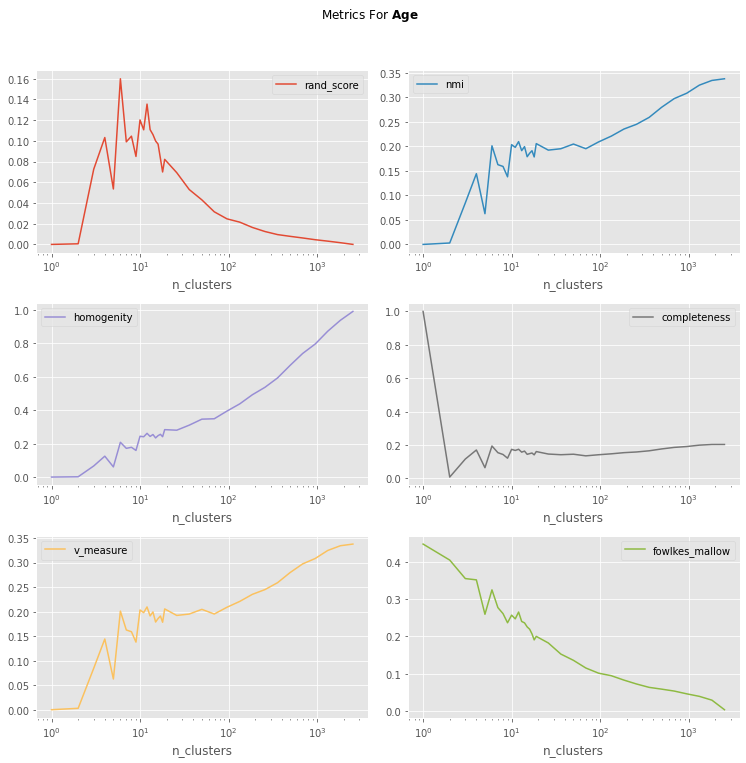

In [43]:
plot_clustering_info(df_age, r"$\bf{Age}$", (11,11))

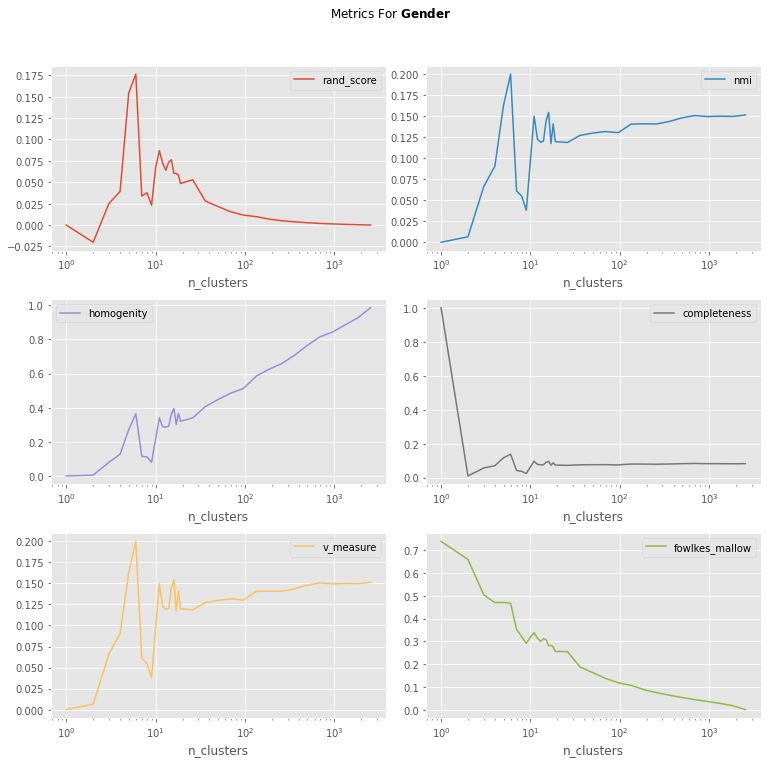

In [45]:
plot_clustering_info(df_gender, r"$\bf{Gender}$", (11,11))

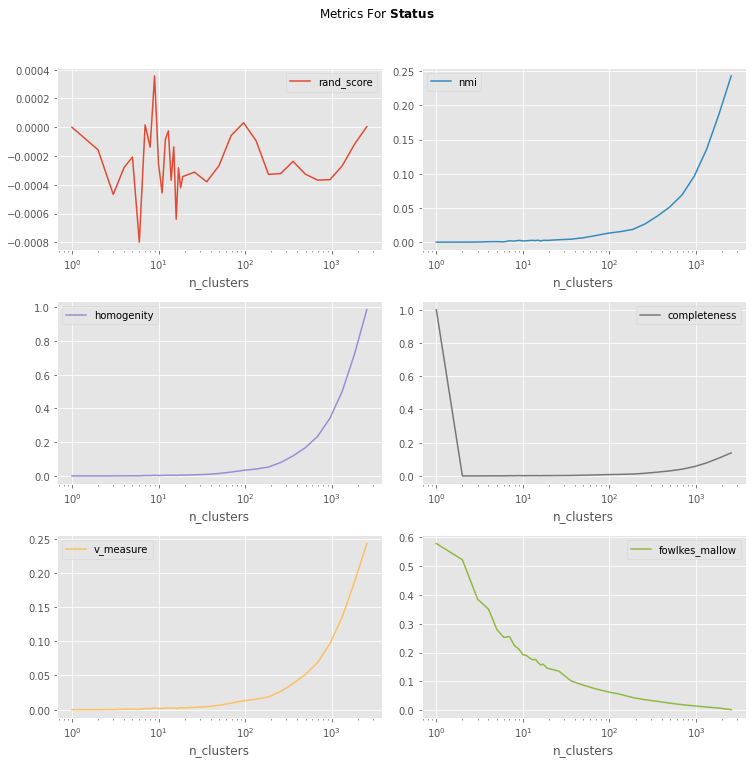

In [46]:
plot_clustering_info(df_status, r"$\bf{Status}$", (11,11))

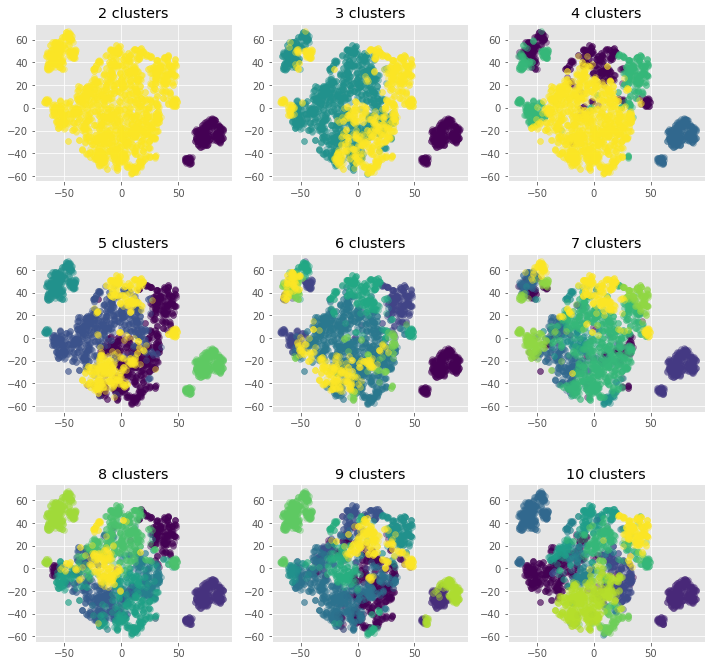

In [38]:
n_clusters = range(2, 11)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for ax, n in zip(axes.flat, n_clusters):
    clst = GaussianMixture(n)
    preds = clst.fit_predict(X)
    cmap = plt.get_cmap("viridis", n)
    for idx in np.unique(preds):
        selected_indices = preds == idx
        ax.scatter(*x2d[selected_indices].T, color=cmap(idx), alpha=0.4)
    ax.set_title(f"{n} clusters")
    ax.set_aspect("equal")
